In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium

In [ ]:
# Load data
file_path = r'C:\Users\rasmu\Desktop\Speciale\filtered_miss_outlier.xlsx'
filtered_df = pd.read_excel(file_path)

Create the time since dry dock feature

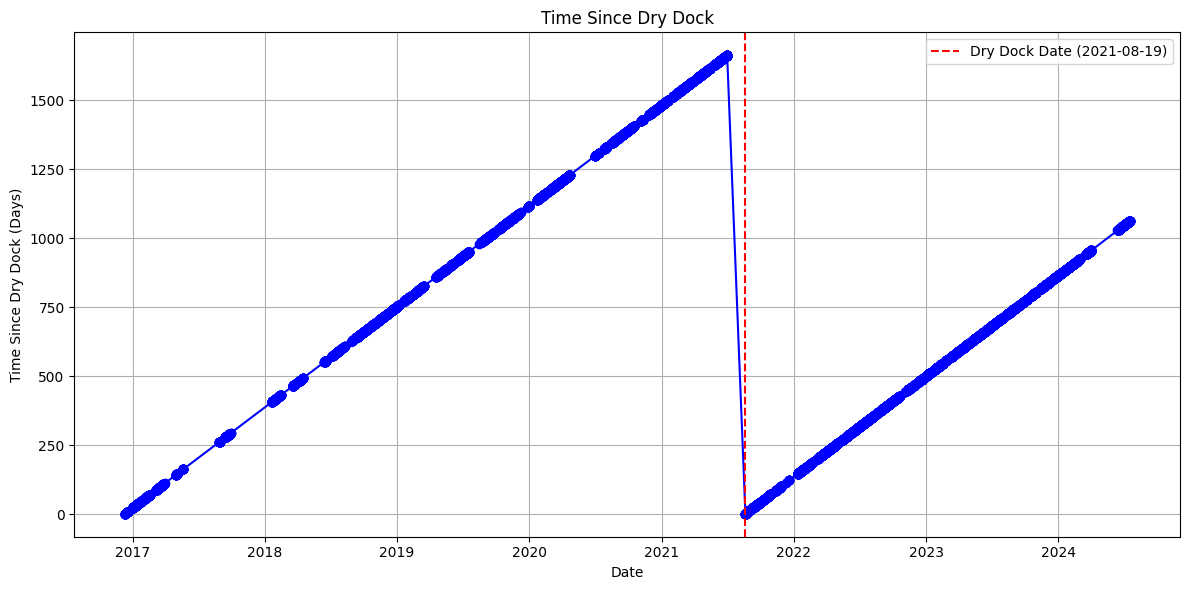

In [2]:
# Load data
file_path = r'C:\Users\rasmu\Desktop\Speciale\filtered_miss_outlier.xlsx'
filtered_df = pd.read_excel(file_path)

# Ensure the 'start' column is in datetime format
filtered_df['start'] = pd.to_datetime(filtered_df['start'])

# Define the dry dock date
dry_dock_date = pd.to_datetime('2021-08-19')

# Calculate the days since dry dock for each date
filtered_df['time_since_dry_dock'] = (filtered_df['start'] - dry_dock_date).dt.days

# Adjust the days before the dry dock date
filtered_df.loc[filtered_df['start'] < dry_dock_date, 'time_since_dry_dock'] = \
    (filtered_df.loc[filtered_df['start'] < dry_dock_date, 'start'] - filtered_df['start'].min()).dt.days + 1

# Adjust the days after and including the dry dock date
filtered_df.loc[filtered_df['start'] >= dry_dock_date, 'time_since_dry_dock'] = \
    (filtered_df.loc[filtered_df['start'] >= dry_dock_date, 'start'] - dry_dock_date).dt.days + 1

# Plotting the time_since_dry_dock
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['start'], filtered_df['time_since_dry_dock'], marker='o', linestyle='-', color='b')
plt.title('Time Since Dry Dock')
plt.xlabel('Date')
plt.ylabel('Time Since Dry Dock (Days)')
plt.axvline(dry_dock_date, color='r', linestyle='--', label='Dry Dock Date (2021-08-19)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

Idea is to visualise where the ship has been to check if the co ordinates are correct. Work in progress.

In [3]:
# Function to calculate distance to the equator
def distance_to_equator(lat):
    R = 6371.0  # Earth's radius in kilometers
    latitudes_rad = np.deg2rad(lat)
    distance = R * np.abs(latitudes_rad)
    return distance

# Apply the function
filtered_df['distance_to_equator'] = distance_to_equator(filtered_df['lat'])

# Function to create a folium map and add markers
def create_map(df):
    # Create a map centered at the average latitude and longitude
    m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=2)
    
    # Add markers to the map
    for _, row in df.iterrows():
        folium.Marker(location=[row['lat'], row['lon']], 
                      popup=f"Lat: {row['lat']}, Lon: {row['lon']}").add_to(m)
    
    return m

Create cos and sin versions of the month.

In [4]:
# Extract month names from the datetime column
filtered_df['month'] = filtered_df['start'].dt.month_name()

# Mapping month names to integers
month_to_int = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
filtered_df['month_num'] = filtered_df['month'].map(month_to_int)

# Cyclical encoding
filtered_df['month_sin'] = np.sin(2 * np.pi * filtered_df['month_num'] / 12)
filtered_df['month_cos'] = np.cos(2 * np.pi * filtered_df['month_num'] / 12)

# Extract hour from the datetime column
filtered_df['hour'] = filtered_df['start'].dt.hour

# Define day and night based on hour (6 AM to 6 PM is day)
filtered_df['day_or_night'] = np.where((filtered_df['hour'] >= 6) & (filtered_df['hour'] < 18), 'day', 'night')

# Binary encoding for day or night
filtered_df['day_or_night_binary'] = np.where(filtered_df['day_or_night'] == 'day', 1, 0)

# Display the resulting DataFrame
print(filtered_df[['start', 'month', 'month_num', 'month_sin', 'month_cos', 'hour', 'day_or_night', 'day_or_night_binary']])

print(filtered_df.shape)

                        start     month  month_num     month_sin  month_cos  \
0     2016-12-10 02:00:00.170  December         12 -2.449294e-16   1.000000   
1     2016-12-10 03:00:00.053  December         12 -2.449294e-16   1.000000   
2     2016-12-10 04:00:00.080  December         12 -2.449294e-16   1.000000   
3     2016-12-10 05:00:00.177  December         12 -2.449294e-16   1.000000   
4     2016-12-10 06:00:00.023  December         12 -2.449294e-16   1.000000   
...                       ...       ...        ...           ...        ...   
28013 2024-07-16 00:00:00.283      July          7 -5.000000e-01  -0.866025   
28014 2024-07-16 01:00:00.263      July          7 -5.000000e-01  -0.866025   
28015 2024-07-16 02:00:00.157      July          7 -5.000000e-01  -0.866025   
28016 2024-07-16 03:00:00.290      July          7 -5.000000e-01  -0.866025   
28017 2024-07-16 04:00:00.253      July          7 -5.000000e-01  -0.866025   

       hour day_or_night  day_or_night_binary  
0  

In [5]:
# show nan values in the dataset
print(filtered_df.isnull().sum())

# remove nan values from the dataset
filtered_df = filtered_df.dropna()

start                  0
end                    0
lat                    0
lat N                  0
lon                    0
lon N                  0
sog mean               0
sog std                0
sog N                  0
cog mean               0
cog std                0
cog N                  0
stw mean               0
stw std                0
stw N                  0
hdt mean               0
hdt std                0
hdt N                  0
wins mean              0
wins std               0
wins N                 0
wind mean              0
wind std               0
wind N                 0
rud mean               0
rud std                0
rud N                  0
pitch mean             0
pitch std              0
pitch N                0
roll mean              0
roll std               0
roll N                 0
spow mean              0
spow std               0
spow N                 0
srpm mean              0
srpm std               0
srpm N                 0
strq mean              0


Create a feature that can represent gaps. 

                    start  time_diff_hours  gap_indicator  gap_length_hours
0 2016-12-10 02:00:00.170              NaN          False          0.000000
1 2016-12-10 03:00:00.053         0.999967          False          0.999967
2 2016-12-10 04:00:00.080         1.000007          False          1.000007
3 2016-12-10 05:00:00.177         1.000027          False          1.000027
4 2016-12-10 06:00:00.023         0.999957          False          0.999957
5 2016-12-10 07:00:00.320         1.000082          False          1.000082
6 2016-12-10 08:00:00.087         0.999935          False          0.999935
7 2016-12-10 09:00:00.083         0.999999          False          0.999999
8 2016-12-10 10:00:00.120         1.000010          False          1.000010
9 2016-12-10 11:00:00.080         0.999989          False          0.999989


C:\Users\rasmu\AppData\Local\Temp\ipykernel_18280\2355107041.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['gap_length_hours'].fillna(0, inplace=True)  # Replace NaN values with 0 for the initial row


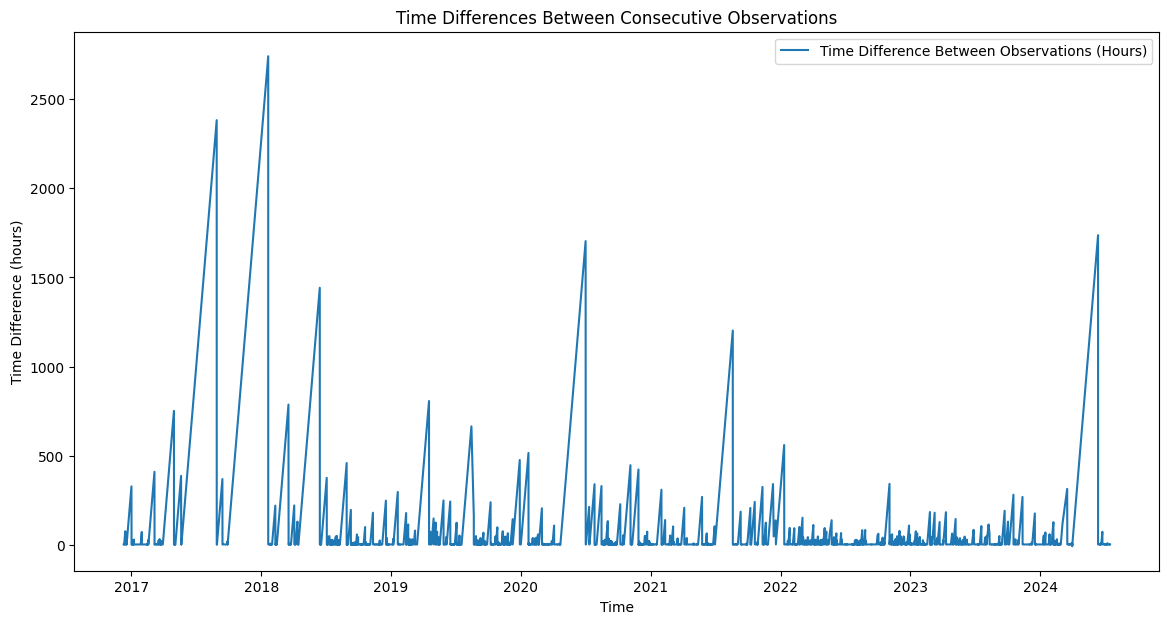

Number of large gaps in the entire dataset: 636
Shape of processed data: (28018, 56)


C:\Users\rasmu\AppData\Local\Temp\ipykernel_18280\2355107041.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df.fillna(method='ffill', inplace=True)
C:\Users\rasmu\AppData\Local\Temp\ipykernel_18280\2355107041.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df.fillna(method='bfill', inplace=True)


In [6]:
# Calculate time differences between consecutive observations for the entire dataset
filtered_df['time_diff_hours'] = filtered_df['start'].diff().dt.total_seconds() / 3600

# Create a binary feature indicating the presence of a gap larger than 2 hours
filtered_df['gap_indicator'] = filtered_df['time_diff_hours'] > 2

# Create a feature for the actual length of the gap in hours
filtered_df['gap_length_hours'] = filtered_df['time_diff_hours']
filtered_df['gap_length_hours'].fillna(0, inplace=True)  # Replace NaN values with 0 for the initial row

# Check the resulting dataframe
print(filtered_df[['start', 'time_diff_hours', 'gap_indicator', 'gap_length_hours']].head(10))

# Plot the time differences for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(filtered_df['start'], filtered_df['time_diff_hours'], label='Time Difference Between Observations (Hours)')
plt.xlabel('Time')
plt.ylabel('Time Difference (hours)')
plt.title('Time Differences Between Consecutive Observations')
plt.legend()
plt.show()

# Check for large gaps (e.g., more than 2 hours) in the entire dataset
large_gaps = filtered_df[filtered_df['time_diff_hours'] > 2]
print(f"Number of large gaps in the entire dataset: {len(large_gaps)}")

# List of relevant features including the gap indicator and gap length
relevant_columns = ['stw mean', 'pitch mean', 'draught aft', 'draught fore', 
                    'stw std', 'time_since_dry_dock', 'distance_to_equator', 
                    'wins mean', 'wind mean', 'roll mean', 'rud std', 
                    'hdt mean', 'srpm std', 'pitch std', 'gap_indicator', 'gap_length_hours']

# Ensure no NaN values remain due to the gap indicator or time difference calculation
filtered_df.fillna(method='ffill', inplace=True)
filtered_df.fillna(method='bfill', inplace=True)

# Check the shape of your input data
print(f"Shape of processed data: {filtered_df.shape}") 

In [7]:
print(filtered_df.shape)

(28018, 56)


Correlation matrix

In [8]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# Ensure gap_indicator is converted to numerical for correlation calculation
filtered_df['gap_indicator'] = filtered_df['gap_indicator'].astype(int)

corr = filtered_df.select_dtypes('number').corr()
corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .set_table_styles(magnify())


,lat,lat N,lon,lon N,sog mean,sog std,sog N,cog mean,cog std,cog N,stw mean,stw std,stw N,hdt mean,hdt std,hdt N,wins mean,wins std,wins N,wind mean,wind std,wind N,rud mean,rud std,rud N,pitch mean,pitch std,pitch N,roll mean,roll std,roll N,spow mean,spow std,spow N,srpm mean,srpm std,srpm N,strq mean,strq std,strq N,draught aft,draught fore,time_since_dry_dock,distance_to_equator,month_num,month_sin,month_cos,hour,day_or_night_binary,time_diff_hours,gap_indicator,gap_length_hours
lat,1.000,0.051,-0.002,0.051,0.040,-0.117,0.051,-0.011,0.024,0.051,0.046,-0.131,0.020,-0.010,0.037,0.051,-0.026,-0.021,-0.009,0.055,-0.020,-0.009,0.061,0.028,-0.011,0.053,0.078,-0.011,0.039,-0.190,-0.011,0.072,-0.039,-0.010,0.063,-0.029,-0.010,0.069,-0.049,-0.010,0.123,0.102,0.238,-0.019,-0.232,0.231,-0.275,-0.000,-0.005,0.010,0.016,0.010
lat N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000
lon,-0.002,-0.035,1.000,-0.035,0.087,-0.051,-0.035,-0.076,0.023,-0.035,0.090,-0.017,-0.017,-0.078,0.029,-0.035,-0.001,-0.047,-0.028,-0.035,0.011,-0.028,-0.043,-0.093,-0.027,0.107,-0.054,-0.028,0.022,-0.083,-0.028,0.114,0.018,-0.028,0.118,-0.010,-0.028,0.116,0.009,-0.028,0.112,0.131,0.187,-0.056,0.152,-0.149,-0.054,0.003,-0.012,-0.001,0.004,-0.001
lon N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000
sog mean,0.040,0.255,0.087,0.255,1.000,-0.024,0.255,-0.068,-0.107,0.255,0.957,0.106,-0.004,-0.076,-0.068,0.255,-0.039,-0.040,-0.014,0.070,-0.032,-0.014,-0.108,-0.118,-0.015,0.288,0.028,-0.014,-0.033,-0.128,-0.014,0.814,0.025,-0.014,0.874,-0.208,-0.014,0.824,-0.066,-0.014,0.265,0.258,-0.053,-0.083,-0.138,0.164,-0.052,0.002,-0.026,-0.003,-0.085,-0.003
sog std,-0.117,0.023,-0.051,0.023,-0.024,1.000,0.023,0.116,0.114,0.023,-0.045,0.311,-0.097,0.114,0.095,0.023,0.038,0.122,0.009,0.034,0.054,0.009,-0.024,-0.007,0.010,0.004,-0.167,0.010,0.004,0.112,0.010,-0.052,0.226,0.009,-0.061,0.192,0.009,-0.045,0.237,0.009,-0.095,-0.064,0.003,0.108,0.071,-0.008,0.098,0.006,-0.003,0.016,0.061,0.016
sog N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000
cog mean,-0.011,0.012,-0.076,0.012,-0.068,0.116,0.012,1.000,0.000,0.012,-0.069,0.066,-0.033,0.948,-0.005,0.012,0.030,-0.004,-0.004,-0.001,-0.002,-0.004,0.050,0.030,-0.004,-0.255,0.016,-0.005,0.121,0.032,-0.005,-0.118,-0.050,-0.004,-0.134,0.027,-0.004,-0.126,-0.047,-0.004,-0.251,-0.248,-0.036,-0.029,0.173,-0.161,-0.090,-0.004,0.006,-0.012,0.005,-0.012
cog std,0.024,0.043,0.023,0.043,-0.107,0.114,0.043,0.000,1.000,0.043,-0.108,0.039,0.016,0.000,0.981,0.043,0.021,0.042,0.026,0.003,0.282,0.026,0.045,0.439,0.024,-0.049,-0.052,0.026,0.027,-0.004,0.026,-0.066,0.279,0.026,-0.094,0.282,0.026,-0.069,0.305,0.026,-0.063,-0.058,0.013,0.075,0.031,-0.022,-0.002,0.009,-0.001,0.041,0.176,0.041
cog N,0.051,1.000,-0.035,1.000,0.255,0.023,1.000,0.012,0.043,1.000,0.224,0.018,0.278,0.010,0.055,1.000,-0.052,0.006,0.287,0.037,0.047,0.287,0.008,0.010,0.287,-0.058,-0.030,0.288,0.033,-0.083,0.288,0.162,0.052,0.288,0.145,0.017,0.288,0.146,0.034,0.288,-0.075,-0.083,-0.062,-0.001,-0.027,0.039,-0.048,0.023,0.018,0.000,-0.017,0.000


In [9]:
# save this file to a new excel file
filtered_df.to_excel(r'C:\Users\rasmu\Desktop\Speciale\filtered_data6.xlsx', index=False)